In [1]:
from __future__ import annotations

import pytorch_lightning as pl
from torch import nn
import torch

from matsciml.datasets.transforms import (
    PeriodicPropertiesTransform,
    PointCloudToGraphTransform,
    FrameAveraging,
)
from matsciml.lightning.data_utils import MatSciMLDataModule
from matsciml.models.base import ScalarRegressionTask
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

In [2]:
from matsciml.models.utils.io import * 
checkpoint_path = "/home/m3rg2000/Simulation/checkpoints-2024/FAENet_250k.ckpt"
task = multitask_from_checkpoint(checkpoint_path)
task.to('cuda')

MultiTask Training module:
MaterialsProjectDataset-regression0
MaterialsProjectDataset-force_regression0

In [3]:
norm_factors={
    "energy_mean": -186.21986734028704,
    "energy_std": 185.10113806014107,
    "corrected_total_energy_mean": -186.21986734028704,
    "corrected_total_energy_std": 185.10113806014107
}

In [4]:
# Load Data
dm = MatSciMLDataModule(
    "MaterialsProjectDataset",
    train_path="/home/m3rg2000/matsciml/Scale_new_lmdb/test_new",#TRAIN_PATH,
    # val_split=VAL_PATH,
    # test_split=VAL_PATH,
    dset_kwargs={
        "transforms": [
            PeriodicPropertiesTransform(cutoff_radius=6.0, adaptive_cutoff=True),
            PointCloudToGraphTransform(
                "pyg",
                node_keys=["pos", "atomic_numbers"],
            ),
            FrameAveraging(frame_averaging="3D", fa_method="stochastic"),
        ],
    },
    batch_size=1,
)

dm.setup()
train_loader = dm.train_dataloader()
dataset_iter = iter(train_loader)
batch = next(dataset_iter)


In [5]:
batch['graph'].ptr

tensor([ 0, 68])

In [6]:
from torch_geometric.data import Data, Batch
# def batch2cuda(batch):
#     for key in batch.keys():
#         if type(batch[key])==torch.Tensor:
#             batch[key]=batch[key].to('cuda')
#     batch['graph']=batch['graph'].to('cuda')
def batch2cuda(batch):
    # Recursively move all tensors in nested structures to 'cuda'
    # batch['graph']=batch['graph'].to('cuda')
    if isinstance(batch, dict):
        return {k: batch2cuda(v) for k, v in batch.items()}
    elif isinstance(batch, list):
        return [batch2cuda(v) for v in batch]
    elif isinstance(batch, torch.Tensor):
        return batch.to('cuda')
    elif isinstance(batch, Data) or isinstance(batch, Batch):
        return batch.to('cuda')
    else:
        return batch
    

In [7]:
batch2cuda(batch)

{'natoms': tensor([[68.]], device='cuda:0'),
 'lattice_features': {'space_group': tensor([[29.]], device='cuda:0'),
  'lattice_params': tensor([[ 5.8154, 11.3487, 14.9877,  1.5708,  1.5708,  1.5708]],
         device='cuda:0')},
 'targets': {'force': tensor([[ 0.0090, -0.2316, -0.2156],
          [-0.0090,  0.2316, -0.2156],
          [-0.0090, -0.2316, -0.2156],
          [ 0.0090,  0.2316, -0.2156],
          [-0.0875,  0.0582, -0.0327],
          [ 0.0875, -0.0582, -0.0327],
          [ 0.0875,  0.0582, -0.0327],
          [-0.0875, -0.0582, -0.0327],
          [-0.1641,  0.0022, -0.2358],
          [ 0.1641, -0.0022, -0.2358],
          [ 0.1641,  0.0022, -0.2358],
          [-0.1641, -0.0022, -0.2358],
          [ 0.0594,  0.1996,  0.0481],
          [-0.0594, -0.1996,  0.0481],
          [-0.0594,  0.1996,  0.0481],
          [ 0.0594, -0.1996,  0.0481],
          [ 0.8277, -0.0019, -0.1660],
          [-0.8277,  0.0019, -0.1660],
          [-0.8277, -0.0019, -0.1660],
          

In [8]:
#torch.set_default_device('cuda')

In [9]:
from tqdm import tqdm
# Initialize lists for storing predictions and actual values
def initialize_prediction_lists():
    return {
        'Predictions_corr_e': [],
        'Actuals_corr_e': [],
        'Predictions_e': [],
        'Actuals_e': [],
        'Predictions_Fx': [],
        'Actuals_Fx': [],
        'Predictions_Fy': [],
        'Actuals_Fy': [],
        'Predictions_Fz': [],
        'Actuals_Fz': []
    }

# Function to process a data loader
def process_data_loader(data_loader, norm_factors, task, limit=None):
    results = initialize_prediction_lists()
    counter = 0

    for batch in tqdm(data_loader):
        batch2cuda(batch)
        Result = task.forward(batch)
        
        Pred_Energy_corr = Result['regression0']['corrected_total_energy'].detach().item() * norm_factors['energy_std'] + norm_factors['energy_mean']
        Pred_Energy = Result['force_regression0']['energy'].detach().item() * norm_factors['energy_std'] + norm_factors['energy_mean']

        Pred_Forces = Result['force_regression0']['force'].detach()* norm_factors['energy_std']+norm_factors['energy_mean']
        Actual_Energy_corr = batch['targets']['energy'].item()
        Actual_Energy = batch['targets']['corrected_total_energy'].detach().item()
        
        Actual_Forces = batch['targets']['force'].detach()

        results['Predictions_corr_e'].append(Pred_Energy_corr)
        results['Actuals_corr_e'].append(Actual_Energy_corr)
        
        results['Predictions_e'].append(Pred_Energy)
        results['Actuals_e'].append(Actual_Energy)
        
        results['Predictions_Fx'] += Pred_Forces[:, 0].reshape(-1).detach().cpu().numpy().tolist()
        results['Actuals_Fx'] += Actual_Forces[:, 0].reshape(-1).detach().cpu().numpy().tolist()

        results['Predictions_Fy'] += Pred_Forces[:, 1].reshape(-1).detach().cpu().numpy().tolist()
        results['Actuals_Fy'] += Actual_Forces[:, 1].reshape(-1).detach().cpu().numpy().tolist()

        results['Predictions_Fz'] += Pred_Forces[:, 2].reshape(-1).detach().cpu().numpy().tolist()
        results['Actuals_Fz'] += Actual_Forces[:, 2].reshape(-1).detach().cpu().numpy().tolist()

        counter += 1
        del batch
        if limit and counter >= limit:
            break

    return results


In [10]:
result=process_data_loader(train_loader, norm_factors, task, limit=10)

  0%|          | 0/196517 [00:00<?, ?it/s]/home/m3rg2000/miniconda3/envs/matsciml/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987290837/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 9/196517 [00:01<6:37:33,  8.24it/s] 


In [16]:
result

{'Predictions_corr_e': [-49.36095699322803,
  -137.1495772826559,
  -334.39287150762095,
  -631.6317493684923,
  -36.40388968585225,
  -64.90552329356503,
  -298.38977904120514,
  -32.348718756574186,
  -397.60829433896436,
  -83.91043342210597],
 'Actuals_corr_e': [-99.25330352783203,
  -139.5116729736328,
  -334.212646484375,
  -550.9456176757812,
  -36.644508361816406,
  -66.7113037109375,
  -291.71746826171875,
  -35.39542770385742,
  -392.33599853515625,
  -79.11248016357422],
 'Predictions_e': [-46.66330565065218,
  -138.9510878478605,
  -334.66824134877004,
  -629.6186004372537,
  -38.76729969914368,
  -64.75564151576906,
  -296.27980548855055,
  -33.473069297126955,
  -404.36423891800393,
  -84.3478984476038],
 'Actuals_e': [-99.25330352783203,
  -139.5116729736328,
  -334.212646484375,
  -550.9456176757812,
  -36.644508361816406,
  -66.7113037109375,
  -291.71746826171875,
  -35.39542770385742,
  -392.33599853515625,
  -79.11248016357422],
 'Predictions_Fx': [-186.251007080078

In [11]:
# Function to plot R² score with train and test data
# Function to plot R² score with train and test data
def plot_r2_score(train_actual, train_pred, test_actual, test_pred, title="Title", suffix="500k_Faenet"):
    save_dir ='/home/m3rg2000/Simulation/plot/'  # Ensure this path ends with a slash

    # Calculate R² score for train and test data
    r2_train = r2_score(train_actual, train_pred)
    r2_test = r2_score(test_actual, test_pred)

    # Create the scatter plot
    plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
    plt.scatter(train_actual, train_pred, label='Train', color='blue')
    plt.scatter(test_actual, test_pred, label='Test', color='green')
    plt.xlabel("Actual", fontsize=20, fontweight='bold')
    plt.ylabel("Predicted", fontsize=20, fontweight='bold')
    plt.xticks(rotation=90, fontsize=20, fontweight='bold')
    plt.yticks(fontsize=20, fontweight='bold')
    # Plot the 45-degree line
    min_val = min(min(train_actual), min(test_actual), min(train_pred), min(test_pred))
    max_val = max(max(train_actual), max(test_actual), max(train_pred), max(test_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    plt.title(title, fontsize=20, fontweight='bold')

    # Annotate the R² scores on the plot
    plt.text(0.05, 0.95, f'Train R² = {r2_train:.5f}', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', verticalalignment='top', color='blue')
    plt.text(0.05, 0.90, f'Test R² = {r2_test:.5f}', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', verticalalignment='top', color='green')

    # Save the plot to the specified location with the title in the filename
    filename = f"{title.replace(' ', '_')}_{suffix}.png"
    plt.savefig(f'{save_dir}{filename}', bbox_inches='tight')  # Use bbox_inches='tight' to adjust the bounding box

    # Show the plot
    plt.show()
    # Clear the current figure to avoid overlap
    plt.clf()



In [12]:
train_results=result
test_results=result

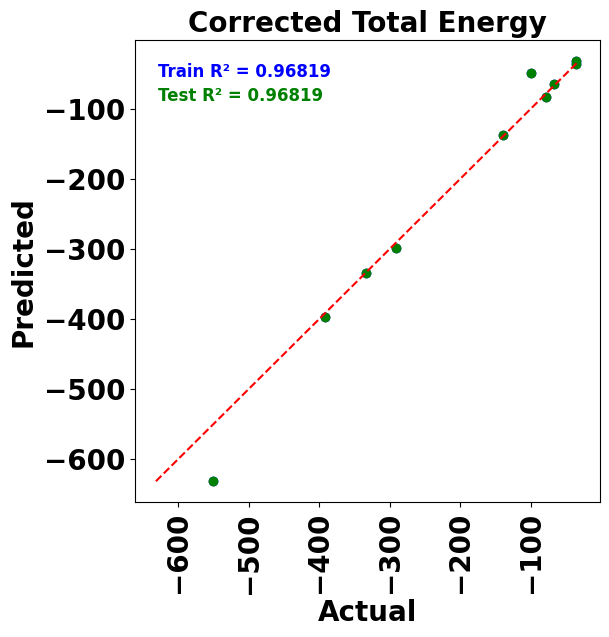

<Figure size 640x480 with 0 Axes>

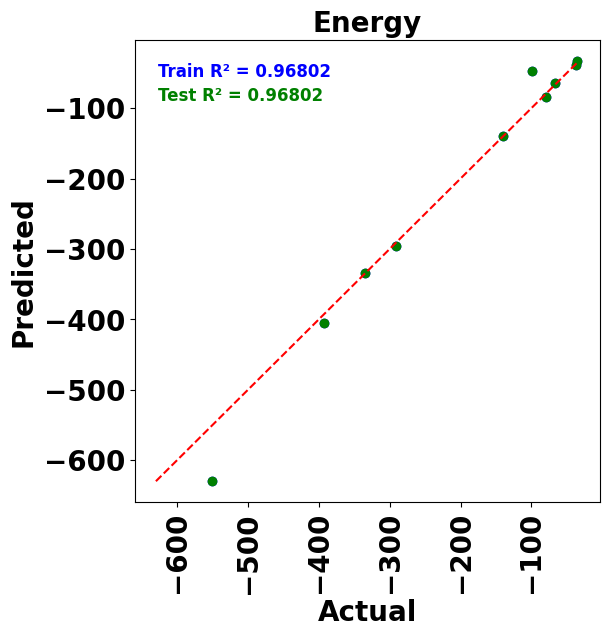

<Figure size 640x480 with 0 Axes>

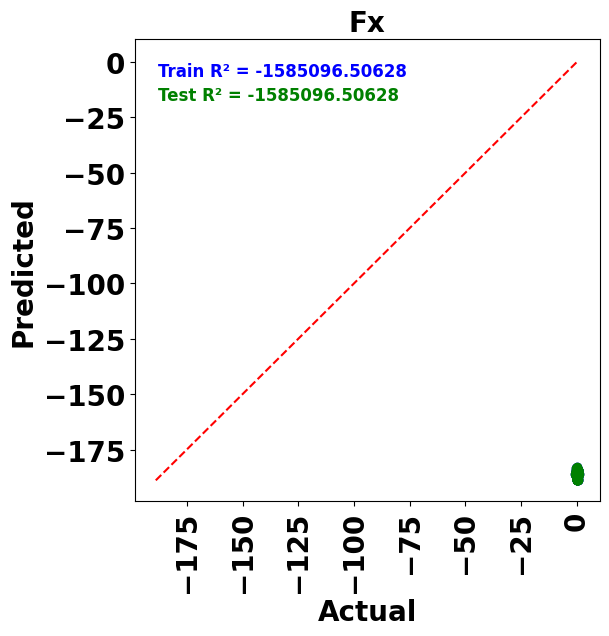

<Figure size 640x480 with 0 Axes>

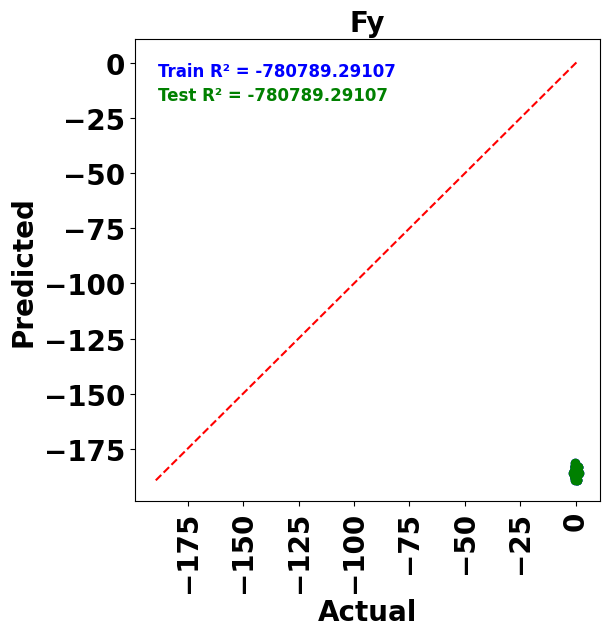

<Figure size 640x480 with 0 Axes>

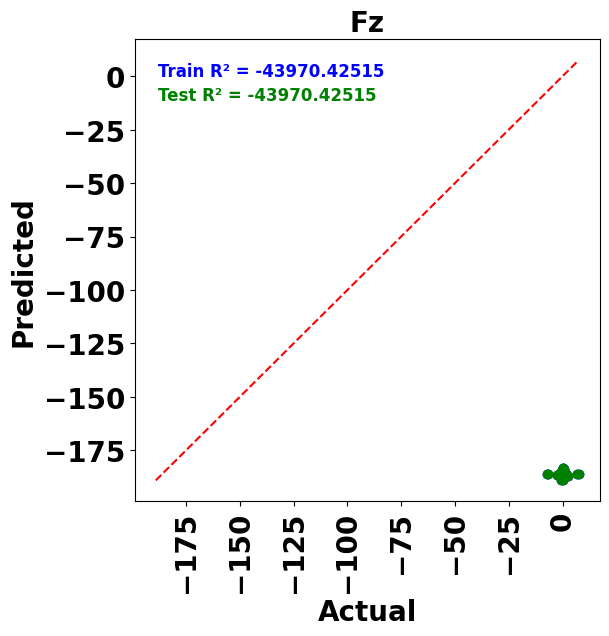

<Figure size 640x480 with 0 Axes>

In [13]:

# Plot and save the results for combined training and test data
plot_r2_score(train_results['Actuals_corr_e'], train_results['Predictions_corr_e'], test_results['Actuals_corr_e'], test_results['Predictions_corr_e'], "Corrected Total Energy", "500k_Faenet")
plot_r2_score(train_results['Actuals_e'], train_results['Predictions_e'], test_results['Actuals_e'], test_results['Predictions_e'], "Energy", "500k_Faenet")
plot_r2_score(train_results['Actuals_Fx'], train_results['Predictions_Fx'], test_results['Actuals_Fx'], test_results['Predictions_Fx'], "Fx", "500k_Faenet")
plot_r2_score(train_results['Actuals_Fy'], train_results['Predictions_Fy'], test_results['Actuals_Fy'], test_results['Predictions_Fy'], "Fy", "500k_Faenet")
plot_r2_score(train_results['Actuals_Fz'], train_results['Predictions_Fz'], test_results['Actuals_Fz'], test_results['Predictions_Fz'], "Fz", "500k_Faenet")


In [14]:
def plot_r2_score(actual,pred,title="Title"):

    # Calculate R² score
    r2 = r2_score(actual, pred)

    # Create the scatter plot
    plt.scatter(actual, pred)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")

    # Plot the 45-degree line
    min_val = min(min(actual), min(pred))
    max_val = max(max(actual), max(pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    plt.title(title)
    # Annotate the R² score on the plot
    plt.text(0.05, 0.95, f'R² = {r2:.5f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    # Show the plot
    plt.show()


In [15]:
plot_r2_score(Actuals_e,Predictions_e,"Energy")
plot_r2_score(Actuals_corr_e,Predictions_corr_e,"Corrected Total Energy")
plot_r2_score(Actuals_Fx,Predictions_Fx,"Fx")
plot_r2_score(Actuals_Fy,Predictions_Fy,"Fy")
plot_r2_score(Actuals_Fz,Predictions_Fz,"Fz")

NameError: name 'Actuals_e' is not defined

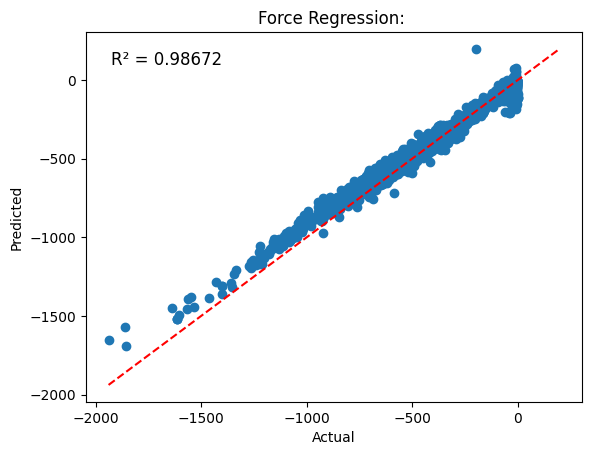

In [ ]:
# Calculate R² score
r2 = r2_score(Actuals_e, Predictions_e)

# Create the scatter plot
plt.scatter(Actuals_e, Predictions_e)
plt.xlabel("Actual")
plt.ylabel("Predicted")

# Plot the 45-degree line
min_val = min(min(Actuals_e), min(Predictions_e))
max_val = max(max(Actuals_e), max(Predictions_e))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.title("Force Regression: ")
# Annotate the R² score on the plot
plt.text(0.05, 0.95, f'R² = {r2:.5f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Show the plot
plt.show()


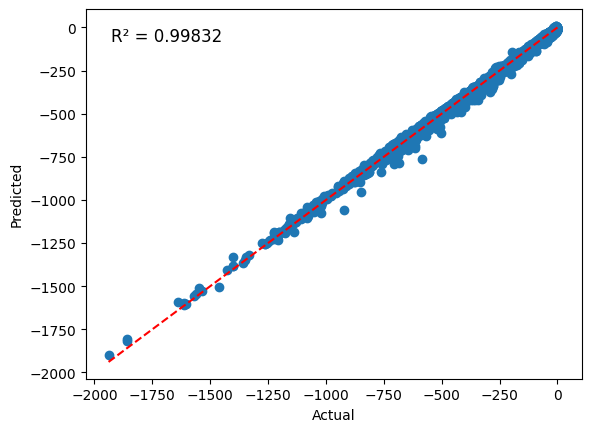

In [ ]:
# Calculate R² score
r2 = r2_score(Actuals_e, Predictions_e)

# Create the scatter plot
plt.scatter(Actuals_e, Predictions_e)
plt.xlabel("Actual")
plt.ylabel("Predicted")

# Plot the 45-degree line
min_val = min(min(Actuals_e), min(Predictions_e))
max_val = max(max(Actuals_e), max(Predictions_e))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Annotate the R² score on the plot
plt.text(0.05, 0.95, f'R² = {r2:.5f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Show the plot
plt.show()
